In [20]:
import gseapy as gsp
import pandas as pd
import scanpy as sc
import anndata as ad
import time

In [22]:
# Time wrapper function
def time_it(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} executed in {end_time - start_time} seconds")
        return result
    return wrapper

In [17]:
# This function filters the leiden clusters that are positive for a specified gene
# diff is boolean specifying if differential expresion is already done
# Default assumes you didn't do your ranked gene expression analysis
# Default method is kept as the default method for the function
# threshold is the threshold of expression
def filter_clusters_by_gene(data, gene, threshold = 0.5, diff = 0, method = None):
    # Load your AnnData object
    adata = data
    if diff == 0:
        sc.tl.rank_genes_groups(adata, groupby = 'leiden', method = method)
    # Extract the DataFrame for the differential expression results
    de_results = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
    # Define a threshold for significant expression (adjust as needed)
    expression_threshold = threshold
    # Find clusters with significant gene expression
    significant_clusters = []
    for cluster in de_results.columns:
        gene_presence = de_results[cluster].str.contains(gene)
        gene_expression = adata.uns['rank_genes_groups']['logfoldchanges'][cluster][gene_presence]
        if any(gene_expression >= expression_threshold):
            significant_clusters.append(cluster)
    # Subset the data to include only cells from the significant clusters
    adata_subset = adata[adata.obs['leiden'].isin(significant_clusters)].copy()
    return adata_subset

In [18]:
# Cell filtering and QC for UMAP
def filter_cells_for_UMAP(data, min_gen = 500, min_cell = 3, mt_pct = 60, normed = 0, doublet_threshold = 0.24, min_ct = 0, max_genes = 0): #min_ct is removed. Consider restoring it later. You will find it commented out below. Max genes is also removed and commented even further below
    # Working default arguments:
    # data, min_gen = 500, min_cell = 3, mt_pct = 60, normed = 0, doublet_threshold = 0.24, min_ct = 0, max_genes = 0
    adata = data # This is to avoid writing into the file that's entered as an argument
    if min_ct > 0:
        sc.pp.filter_cells(adata, min_counts = min_ct) # Filter cells based on number of RNA reads
    sc.pp.filter_cells(adata, min_genes= min_gen) # Filter cells based on the number of recognized genes
    sc.pp.filter_genes(adata, min_cells = min_cell) # Filter genes based on the minimum number of cells expressing it
    adata_prefilt = adata[adata.obs['doublet_scores'] < doublet_threshold]
    if max_genes > 0:
        adata_prefilt = adata_prefilt[adata_prefilt.obs['n_genes_by_counts'] < max_genes]
        
    if not normed:
        adata_filt = adata_prefilt[adata_prefilt.obs['pct_counts_mt'] < mt_pct] # Filtering based on percentage of mitochondrial genes
    else:
        adata_filt = adata_prefilt
    return adata_filt    

In [23]:
# Processing for UMAP from QC all the way to the end
@time_it # Timing wrapper for benchmarking purposes. Can comment out
def process_for_UMAP(data, normed = 0, leiden_res = 0.8, filtering = 1, min_gen = 500, min_cell = 3, mt_pct = 60, neighbors = 50): # DEFAULT QC VALUES
    # Working default arguments:
    # data, normed = 0, leiden_res = 0.8, filtering = 1, min_gen = 500, min_cell = 3, mt_pct = 60, neighbors = 15
    adata = data # This is to avoid writing into the file that's entered as an argument
    if filtering:
        adata_filt = filter_cells_for_UMAP(data = adata, min_gen = min_gen, min_cell = min_cell, mt_pct = mt_pct) #min ct is removed. Think about restoring it later.
    else:
        adata_filt = adata       
    sc.pp.normalize_total(adata_filt, target_sum=1e4) # Normalize
    sc.pp.log1p(adata_filt) # Log scaling
    sc.pp.highly_variable_genes(adata_filt, min_mean = 0.0125, max_mean = 3, min_disp = 0.5) # Compute differentially expressed genes within the sample
    adata_filt.raw = adata_filt # Store the raw files in its own layer
    adata_filt = adata_filt[:, adata_filt.var.highly_variable] # Filter on genes that are highly variable
    sc.pp.regress_out(adata_filt, ['total_counts', 'pct_counts_mt']) # Regression. Not sure what that is.
    sc.pp.scale(adata_filt, max_value = 10) # Scale the data
    sc.tl.pca(adata_filt, svd_solver='arpack') # Compute PCA
    sc.tl.tsne(adata_filt) # Calculate tsne
    sc.pp.neighbors(adata_filt, n_neighbors = neighbors) # Calculate neighbors
    sc.tl.leiden(adata_filt, resolution = leiden_res) # Calculate Leiden clusters
    sc.tl.paga(adata_filt) # Calculate PAGA
    sc.pl.paga(adata_filt, plot = 1)  # remove `plot=False` if you want to see the coarse-grained graph
    sc.tl.umap(adata_filt, init_pos='paga') # Plot PAGA
    sc.tl.umap(adata_filt) # Calculate UMAP
    sc.pl.umap(adata_filt, color = ['leiden']) # Plot UMAP and show Leiden clusters
    return adata_filt

In [5]:
path = 'S:/data cache/code_in_out/agr2/script_0_out/'
comb_ant = sc.read_h5ad(path + 'antrum_proc.h5ad')

In [12]:
#%% Read the files
path = 'S:/data cache/code_in_out/agr2/agr2_init_files/Aline/raw_data/'
ant_unfilt = sc.read_h5ad(path + 'agr2_unfilt_antrum.h5ad')

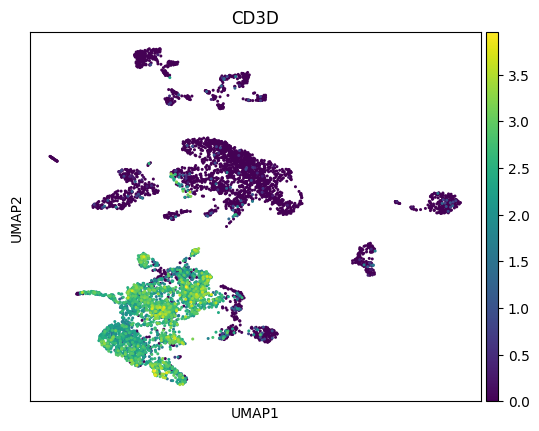

In [7]:
sc.pl.umap(comb_ant, color = 'CD3D')

In [10]:
comb_ant_filt = filter_clusters_by_gene(comb_ant, gene = 'EPCAM', method = 'wilcoxon')

C:\anaconda_envs\spyder\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\anaconda_envs\spyder\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\anaconda_envs\spyder\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

In [14]:
barcodes = comb_ant_filt.obs_names.tolist()

In [16]:
comb_ant_refilt = ant_unfilt[barcodes]

C:\anaconda_envs\spyder\Lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\anaconda_envs\spyder\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\anaconda_envs\spyder\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


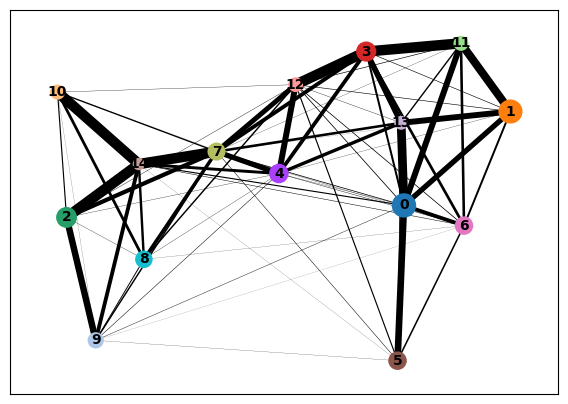

C:\anaconda_envs\spyder\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


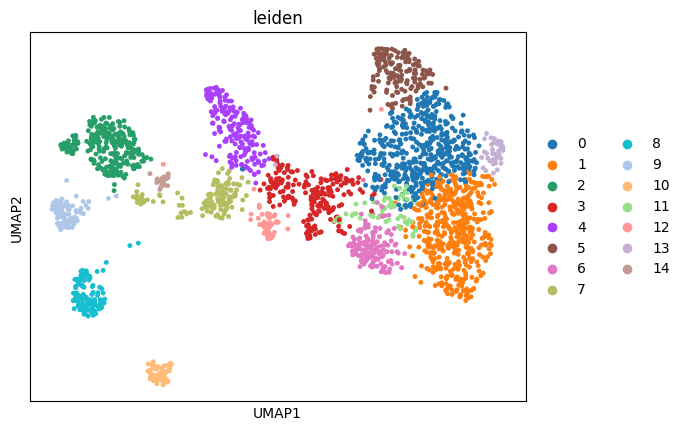

process_for_UMAP executed in 30.543677806854248 seconds


In [24]:
ant_reproc = process_for_UMAP(comb_ant_refilt, filtering = 0)

In [27]:
print(ant_reproc.obs['Patient'])

AAACGGGTCGGTTCGG-1-JAB8687A25       P26
AAAGATGCAGTCGTGC-1-JAB8687A25       P26
AAAGATGCATTGAGCT-1-JAB8687A25       P26
AAAGATGGTATCAGTC-1-JAB8687A25       P26
AAAGATGTCACCTCGT-1-JAB8687A25       P26
                                  ...  
TTTGTCAAGTTCGCGC-1-JAB8687A28    GI6253
TTTGTCACATCCGGGT-1-JAB8687A28    GI6253
TTTGTCATCAGTACGT-1-JAB8687A28    GI6253
TTTGTCATCTGATACG-1-JAB8687A28    GI6253
TTTGTCATCTGTCAAG-1-JAB8687A28    GI6253
Name: Patient, Length: 2440, dtype: category
Categories (2, object): ['GI6253', 'P26']


In [30]:
sc.tl.rank_genes_groups(ant_reproc, method = 'wilcoxon', groupby = 'Patient', reference = 'GI6253')

In [32]:
# Extracting results
result = ant_reproc.uns['rank_genes_groups']
groups = result['names'].dtype.names

# Convert results to a DataFrame
de_results = pd.DataFrame({
    'gene': result['names'][groups[0]],
    'pvals': result['pvals'][groups[0]],
    'logfoldchanges': result['logfoldchanges'][groups[0]]
})

In [39]:
str(de_results)

'           gene          pvals  logfoldchanges\n0          GHRL  4.559772e-155       10.320201\n1         PHGR1  3.829664e-152        4.433203\n2      SERPINA1  1.056626e-120        4.453507\n3         CLDN7  6.469078e-113        3.537046\n4          REG4  1.198119e-104        6.913313\n...         ...            ...             ...\n36596      MUC1  2.663292e-211       -3.885129\n36597    CLDN18  1.959834e-219       -3.572167\n36598       PGC  8.319906e-239       -6.416009\n36599      MSMB  4.595543e-241      -10.845753\n36600      GAST  6.232949e-270      -14.972279\n\n[36601 rows x 3 columns]'

In [33]:
# Create a list of genes for GSEA (e.g., significant genes)
significant_genes = de_results[de_results['pvals'] < 0.05]['gene'].tolist()

In [40]:
gsea_res = gsp.gsea(
    data=de_results,  # DataFrame with gene names and statistics
    gene_sets='Reactome_2022',  # Gene set database
    cls=['GI6253', 'P26'],  # Class labels
    permutation_type='gene_set',  # Permutation type
    method='signal_to_noise',  # Metric for ranking genes
    min_size=15,  # Minimum gene set size
    max_size=500,  # Maximum gene set size
    permutation_num=100,  # Number of permutations
    outdir='gsea_results',  # Output directory
    format='png',  # Output format
)

PanicException: called `Option::unwrap()` on a `None` value